In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import laspy
import os
import math
from matplotlib import cm
from matplotlib.colors import ListedColormap
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize, ListedColormap, BoundaryNorm
import matplotlib.colors as mcolors


# Sample building

In [2]:
basePath = "/home/jaumeasensio/Documents/Projectes/BEEGroup/solar_potencial_estimation_v3/"
neighborhood = "Test_70_el Besòs i el Maresme"
parcelsFolder = basePath + "/Results/" + neighborhood + "/Parcels/"
parcel = "4157903DF3845E"
construction = "86"

## Plot LiDAR data

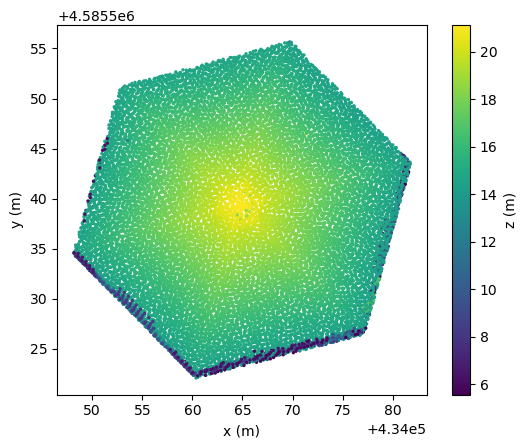

In [342]:
constructionFolder = parcelsFolder + parcel + "/" + construction
laz_file = constructionFolder + "/Map files/" + construction + ".laz"
lasDF = laspy.read(laz_file)
x = lasDF.x
y = lasDF.y
z = lasDF.z

fig, ax = plt.subplots()
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')

scatter = ax.scatter(x, y, c=z, cmap='viridis', s=2)
cb = plt.colorbar(scatter)
cb.set_label('z (m)')

ax.set_aspect("equal", adjustable='box')
plt.savefig("/home/jaumeasensio/Documents/TFM/Redacció memòria/Figures/Plane Identification/LiDAR_Sample.png",bbox_inches='tight')

## Get histogram

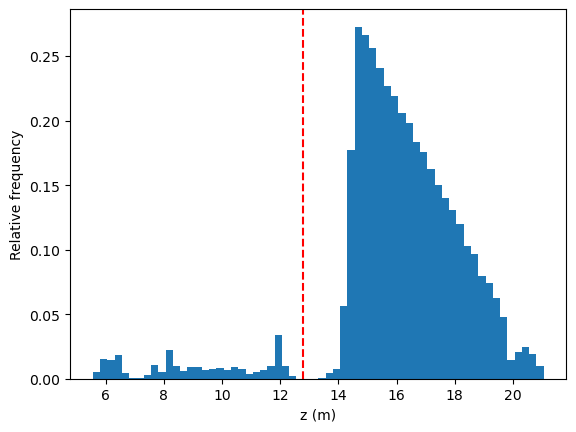

In [343]:
constructionFolder = parcelsFolder + parcel + "/" + construction
laz_file = constructionFolder + "/Map files/" + construction + ".laz"
lasDF = laspy.read(laz_file)
x = lasDF.x
y = lasDF.y
z = lasDF.z

distance_threshold = 0.5
fig, ax = plt.subplots()
Z = np.array(lasDF.z)
Z = Z[Z.argsort()]         
deltaZ = np.diff(Z, prepend=0)

heightSplits = []
for i in range(1, len(deltaZ)):
    if deltaZ[i] > distance_threshold:
        heightSplits.append(Z[i-1])

bins = np.arange(np.min(Z), np.max(Z), 0.5*distance_threshold)
ax.hist(Z, bins, density=True)
ax.set_xlabel("z (m)")
ax.set_ylabel("Relative frequency")

for split in heightSplits:
    ax.axvline(x=split+0.5*distance_threshold, color='red', linestyle='--', linewidth=1.5)

# plt.savefig("/home/jaumeasensio/Documents/TFM/Redacció memòria/Figures/Plane Identification/Histogram.png",bbox_inches='tight')

/tmp/ipykernel_256883/2727730499.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', len(unique_clusters))  # or another colormap


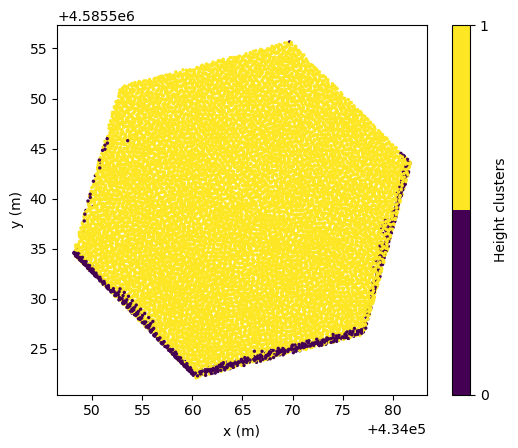

In [344]:
from planeIdentification import *
from getVoronoiClipped import getVoronoiClipped
from planeProcessing import *
from sklearn.cluster import DBSCAN, KMeans

pipeline = ClusterPipeline([
    HeightSplit(distance_threshold = 0.5)
])

pipeline.fit(lasDF.xyz)
lasDF.classification  = pipeline.final_labels

fig, ax = plt.subplots()
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')

unique_clusters = np.unique(lasDF.classification)
cmap = cm.get_cmap('viridis', len(unique_clusters))  # or another colormap
scatter = ax.scatter(x, y, c=lasDF.classification, s=2, cmap=cmap)

# Create colorbar with discrete ticks
cb = plt.colorbar(scatter)
cb.set_label('Height clusters')
cb.set_ticks(np.arange(len(unique_clusters)))  # Set ticks to the number of unique clusters
cb.set_ticks(unique_clusters)  # Ensure the ticks match the clusters


ax.set_aspect("equal", adjustable='box')
# plt.savefig("/home/jaumeasensio/Documents/TFM/Redacció memòria/Figures/Plane Identification/LiDAR_HeightSplit.png",bbox_inches='tight')

## Plane Gradient

In [157]:
def computeGradients(X, squareSize = 2, polar = True):
    gradients = np.zeros((X.shape[0], 2))
    for i, (x, y, z) in enumerate(X):
        neighbors = X[(np.abs(X[:, 0] - x) <= squareSize/2) & (np.abs(X[:, 1] - y) <= squareSize/2)]
        
        delta_x = neighbors[:, 0] - x
        delta_y = neighbors[:, 1] - y
        delta_z = neighbors[:, 2] - z
        
        valid_dx = delta_x != 0
        valid_dy = delta_y != 0
        
        # Compute sum(deltaZ / deltaX) and sum(deltaZ / deltaY)
        sum_dz_dx = np.sum(delta_z[valid_dx] / delta_x[valid_dx])
        sum_dz_dy = np.sum(delta_z[valid_dy] / delta_y[valid_dy])
        
        # Store the gradient
        gradients[i] = [sum_dz_dx/len(valid_dx), sum_dz_dy/len(valid_dx)]

    if(polar):
        polar_gradients = np.zeros(gradients.shape)
        polar_gradients[:, 0] = np.sqrt(gradients[:, 0]**2 + gradients[:, 1]**2)
        polar_gradients[:, 1] = np.arctan2(gradients[:, 0], gradients[:, 1])*180/math.pi+180
        return polar_gradients
    else:
        return gradients
    
gradients = computeGradients(lasDF.xyz[np.where(lasDF.classification == 1)], polar = True)
gradients


array([[5.05354632e-01, 3.53255213e+02],
       [4.89176815e-01, 2.39207198e+02],
       [1.17601889e-01, 2.96169591e+02],
       ...,
       [2.56361540e+00, 1.00310061e+02],
       [5.62457304e-01, 1.87770347e+02],
       [5.91201646e-01, 2.26882536e+02]])

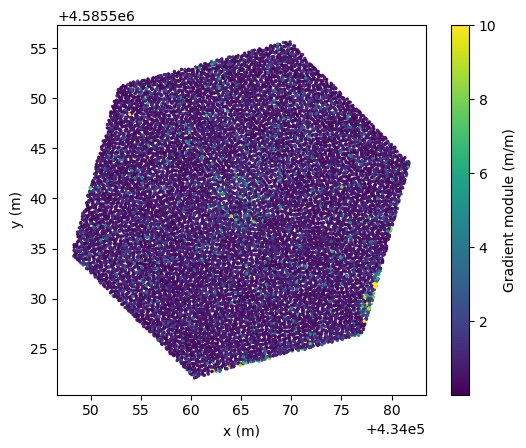

/tmp/ipykernel_256883/2704478356.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cb.ax.set_yticklabels([f"{tick:.0f}°" for tick in cbar_ticks])  # Add ° to each tick


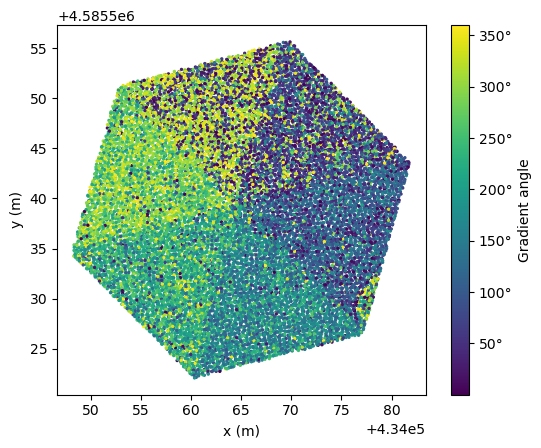

In [164]:

x = lasDF.x[np.where(lasDF.classification == 1)]
y = lasDF.y[np.where(lasDF.classification == 1)]

fig, ax = plt.subplots()
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')


scatter = ax.scatter(x, y, c=np.minimum(gradients[:, 0], 10), cmap='viridis', s=2)
cb = plt.colorbar(scatter)laz_file = constructionFolder + "/Map files/" + construction + ".laz"
ax.set_ylabel('y (m)')

scatter = ax.scatter(x, y, c=gradients[:,1], cmap='viridis', s=2)
cb = plt.colorbar(scatter)
cbar_ticks = cb.ax.get_yticks()  # Get current colorbar ticks
cb.ax.set_yticklabels([f"{tick:.0f}°" for tick in cbar_ticks])  # Add ° to each tick
cb.set_label('Gradient angle')

ax.set_aspect("equal", adjustable='box')
# plt.title("Gradient angle")
plt.savefig("/home/jaumeasensio/Documents/TFM/Redacció memòria/Figures/Plane Identification/Gradient_Angle.png",bbox_inches='tight')
plt.show()

In [156]:
lasDF.classification

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

## Voronoi Diagram

In [167]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from shapely.geometry import Polygon, MultiPoint, MultiPolygon, GeometryCollection, Point
from shapely import make_valid, intersection
from shapely.ops import unary_union
from scipy.spatial import Voronoi

def get_boundary(bound, offset = 100, steps=10):
    x_bottom_top = np.linspace(bound[0] - offset, bound[2] + offset, steps)
    y_left_right = np.linspace(bound[1] - offset, bound[3] + offset, steps)

    bottom_points = np.column_stack([x_bottom_top, np.repeat(bound[1] - offset, steps)])
    top_points = np.column_stack([x_bottom_top, np.repeat(bound[3] + offset, steps)])
    left_points = np.column_stack([np.repeat(bound[0] - offset, steps), y_left_right])
    right_points = np.column_stack([np.repeat(bound[2] + offset, steps), y_left_right])
    boundarycoords = np.vstack([bottom_points, top_points, left_points, right_points])
    boundarycoords = np.unique(boundarycoords, axis=0)
    return boundarycoords

def obtainLabelsPolygons(vorAll, labels):
    voronoi_polygons_list = []
    clustersPolygons = []

    for idx_region, region in enumerate(vorAll.regions):
        if(region):
            indices = np.where(vorAll.point_region[0:len(labels)] == idx_region)
            selectedLabels = labels[indices]
            if -1 not in region:
                if(np.all(selectedLabels == selectedLabels[0])):
                    polygon = Polygon(vorAll.vertices[region])
                    clustersPolygons.append(selectedLabels[0])
                    voronoi_polygons_list.append(polygon)
                else:   
                    try:
                        outline = Polygon(vorAll.vertices[region])
                        points = vorAll.points[indices]
                        if(not np.all((points == points[0]).all())):
                            boundarycoords = get_boundary(outline.bounds)
                            allPoints = np.concatenate((points[:,0:2], boundarycoords))
                            miniVor = Voronoi(allPoints)
                            subVorList, subClusterList = obtainLabelsPolygons(miniVor, selectedLabels)
                            subVorList = [intersection(x.buffer(0), outline.buffer(0)) for x in subVorList]
                            voronoi_polygons_list += subVorList
                            clustersPolygons += subClusterList
                        else:
                            clustersPolygons.append(selectedLabels[0])
                            voronoi_polygons_list.append(outline)
                    except RecursionError:
                        # print("There was an Infinite Recursion Error!")
                        clustersPolygons.append(selectedLabels[0])
                        outline = Polygon(vorAll.vertices[region])
                        voronoi_polygons_list.append(outline)

    return voronoi_polygons_list, clustersPolygons

def getVoronoiClipped(points, labels, cadasterGDF):

    boundarycoords = get_boundary(cadasterGDF.geometry.total_bounds)
    allPoints = np.concatenate((points[:,0:2], boundarycoords))
    vorAll = Voronoi(allPoints)


    # extract valid polygons
    voronoi_polygons_list = []
    clustersPolygons = []

    # for i in range(len(points)):
    #     idx_region = vorAll.point_region[i]
    #     if -1 not in vorAll.regions[idx_region]:
    #         polygon = Polygon(vorAll.vertices[vorAll.regions[idx_region]])
    #         clustersPolygons.append(labels[i])
    #         voronoi_polygons_list.append(polygon)

    voronoi_polygons_list, clustersPolygons = obtainLabelsPolygons(vorAll, labels)

    vorGDF = gpd.GeoDataFrame({"geometry":voronoi_polygons_list, "cluster":clustersPolygons}, crs=cadasterGDF.crs)
    
    vorGDF["geometry"] = vorGDF.geometry.apply(make_valid)
    vorGDF["geometry"] = vorGDF["geometry"].buffer(0.01)
    vorGDF["geometry"] = vorGDF["geometry"].buffer(-0.01)
    merged_gdf = vorGDF    
    merged_gdf["geometry"] = merged_gdf["geometry"].apply(unary_union)
    clippedGDF = gpd.clip(merged_gdf, cadasterGDF, sort=True)

    return clippedGDF

In [175]:
cadasterPath = constructionFolder + "/Map files/" + construction + ".gpkg"
cadasterGDF = gpd.read_file(cadasterPath)

newLasFile = constructionFolder + "/Plane Identification/" + construction + ".laz"
newLasDF = laspy.read(newLasFile)

clippedGDF = getVoronoiClipped(newLasDF.xyz, newLasDF.classification, cadasterGDF)

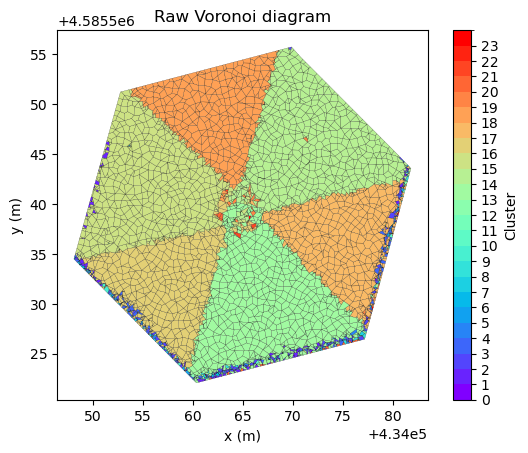

In [243]:
fig, ax = plt.subplots()  # Adjust figure size if needed figsize=(10, 8)


# Define the number of discrete bins
clusters = sorted(clippedGDF["cluster"].unique())  # Get unique cluster values
num_clusters = len(clusters)

# Set up the colormap and boundaries
cmap = plt.get_cmap("rainbow", num_clusters)  # Discrete version of the colormap
boundaries = np.arange(min(clusters), max(clusters) + 2)  # Create boundaries for the clusters
norm = BoundaryNorm(boundaries, cmap.N, extend="neither")

clippedGDF.plot(
    column="cluster",
    edgecolor="black",
    linewidth=0.125,
    cmap=cmap,
    norm=norm,
    ax=ax
)

# Add the discrete colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Required for ScalarMappable
cbar = fig.colorbar(sm, ax=ax, boundaries=boundaries, ticks=clusters)
cbar.set_label("Cluster")  # Label for the colorbar

ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")

plt.title("Raw Voronoi diagram")

plt.savefig("/home/jaumeasensio/Documents/TFM/Redacció memòria/Figures/Plane Identification/Voronoi_Building.png", dpi=300, bbox_inches="tight")  # Use bbox_inches to prevent clipping
plt.show()


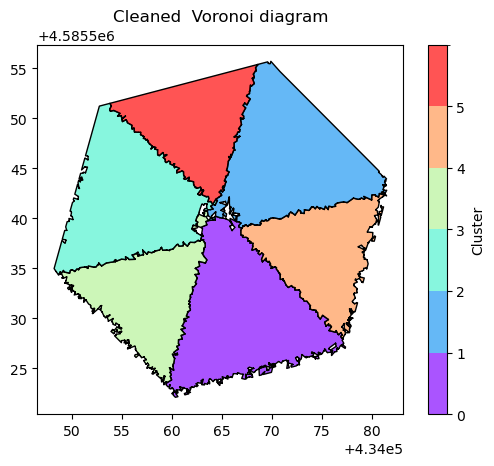

In [242]:
cleanCadasterPath = constructionFolder + "/Plane Identification/" + construction + ".gpkg"
cleanGDF = gpd.read_file(cleanCadasterPath)
cleanGDF["cluster"] = cleanGDF["cluster"] - cleanGDF["cluster"].min()

fig, ax = plt.subplots()  # Adjust figure size if needed figsize=(10, 8)

# Define the number of discrete bins
clusters = sorted(cleanGDF["cluster"].unique())  # Get unique cluster values
num_clusters = len(clusters)

# Set up the colormap and boundaries
cmap = plt.get_cmap("rainbow", num_clusters)  # Discrete version of the colormap
cmap = mcolors.ListedColormap(cmap(np.arange(num_clusters)), name='Pastel1_with_alpha')
cmap.colors[:, -1] = 0.67
boundaries = np.arange(min(clusters), max(clusters) + 2)  # Create boundaries for the clusters
norm = BoundaryNorm(boundaries, cmap.N, extend="neither")

cleanGDF.plot(
    column="cluster",
    edgecolor="black",
    linewidth=1,
    cmap=cmap,
    norm=norm,
    ax=ax
)

# Add the discrete colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Required for ScalarMappable
cbar = fig.colorbar(sm, ax=ax, boundaries=boundaries, ticks=clusters)
cbar.set_label("Cluster")  # Label for the colorbar

plt.title("Cleaned  Voronoi diagram")

plt.savefig("/home/jaumeasensio/Documents/TFM/Redacció memòria/Figures/Plane Identification/Voronoi_Cleaned.png", dpi=300, bbox_inches="tight")  # Use bbox_inches to prevent clipping
plt.show()

## Plane extraction algorithm

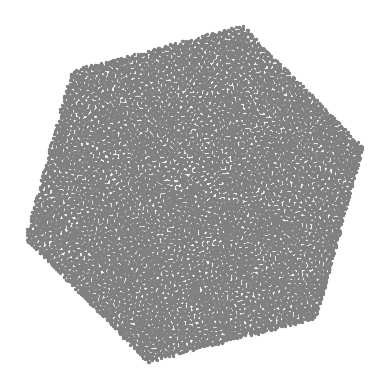

In [330]:
x = newLasDF.x
y = newLasDF.y
z = newLasDF.z
classification = newLasDF.classification

x = x[np.where(classification > 12)]
y = y[np.where(classification > 12)]

This will not be visible for shading, but the information will be obtained in the solar simulation.
# ax.set_ylabel('y (m)')
ax.set_xticks([])
ax.set_yticks([])
ax.grid(False)
for spine in ax.spines.values():
    spine.set_visible(False)

# scatter = ax.scatter(x, y, c=z, cmap='viridis', s=2)
scatter = ax.scatter(x, y, c="gray", s=2)
# cb = plt.colorbar(scatter)
# cb.set_label('z (m)')

ax.set_aspect("equal", adjustable='box')
plt.savefig("/home/jaumeasensio/Documents/TFM/Redacció memòria/Figures/Plane Identification/Steps SubFigures/Unidentified.png",dpi=200, bbox_inches='tight')
plt.show()


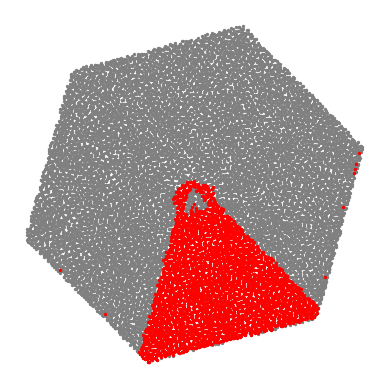

In [331]:
mask = classification == 13

fig, ax = plt.subplots()
# ax.set_xlabel('x (m)')
# ax.set_ylabel('y (m)')
ax.set_xticks([])
ax.set_yticks([])
ax.grid(False)
for spine in ax.spines.values():
    spine.set_visible(False)

# scatter = ax.scatter(x, y, c=z, cmap='viridis', s=2)
scatter = ax.scatter(x, y, c="gray", s=2)
# cb = plt.colorbar(scatter)
# cb.set_label('z (m)')
scatter = ax.scatter(x[mask], y[mask], c="red", s=2)

ax.set_aspect("equal", adjustable='box')
plt.savefig("/home/jaumeasensio/Documents/TFM/Redacció memòria/Figures/Plane Identification/Steps SubFigures/1 Plane.png",dpi=200, bbox_inches='tight')
plt.show()

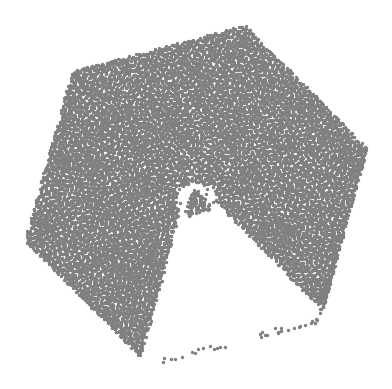

In [332]:
mask = classification == 13

fig, ax = plt.subplots()
# ax.set_xlabel('x (m)')
# ax.set_ylabel('y (m)')
ax.set_xticks([])
ax.set_yticks([])
ax.grid(False)
for spine in ax.spines.values():
    spine.set_visible(False)

# scatter = ax.scatter(x[~mask], y[~mask], c=z[~mask], cmap='viridis', s=2)
scatter = ax.scatter(x[~mask], y[~mask], c="gray", s=2)
# cb = plt.colorbar(scatter)
# cb.set_label('z (m)')

ax.set_aspect("equal", adjustable='box')
plt.savefig("/home/jaumeasensio/Documents/TFM/Redacció memòria/Figures/Plane Identification/Steps SubFigures/Subtracted.png",dpi=200, bbox_inches='tight')
plt.show()

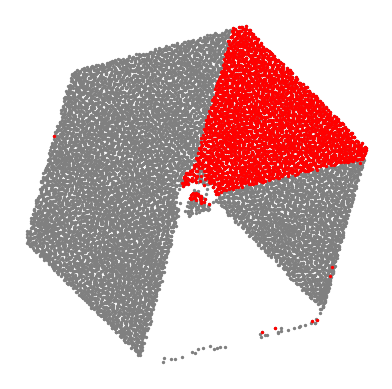

In [333]:
mask = classification == 13

fig, ax = plt.subplots()
# ax.set_xlabel('x (m)')
# ax.set_ylabel('y (m)')
ax.set_xticks([])
ax.set_yticks([])
ax.grid(False)
for spine in ax.spines.values():
    spine.set_visible(False)

# scatter = ax.scatter(x[~mask], y[~mask], c=z[~mask], cmap='viridis', s=2)
scatter = ax.scatter(x[~mask], y[~mask], c="gray", s=2)
# cb = plt.colorbar(scatter)
# cb.set_label('z (m)')

mask = classification == 14
scatter = ax.scatter(x[mask], y[mask], c="red", s=2)

ax.set_aspect("equal", adjustable='box')
plt.savefig("/home/jaumeasensio/Documents/TFM/Redacció memòria/Figures/Plane Identification/Steps SubFigures/2 planes.png",dpi=200, bbox_inches='tight')
plt.show()

## K-planes algorithm

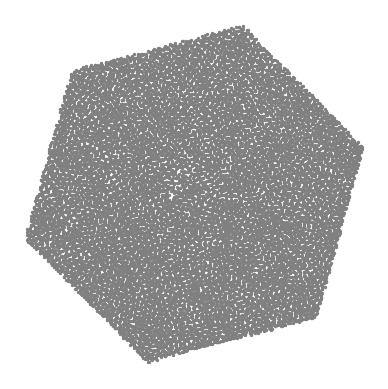

In [336]:
x = newLasDF.x
y = newLasDF.y
z = newLasDF.z
classification = newLasDF.classification

x = x[(classification > 12) & (classification < 19)]
y = y[(classification > 12) & (classification < 19)]
z = z[(classification > 12) & (classification < 19)]
classification = classification[(classification > 12) & (classification < 19)]

fig, ax = plt.subplots()
# ax.set_xlabel('x (m)')
# ax.set_ylabel('y (m)')
ax.set_xticks([])
ax.set_yticks([])
ax.grid(False)
for spine in ax.spines.values():
    spine.set_visible(False)

scatter = ax.scatter(x, y, c="gray", s=2)
# cb = plt.colorbar(scatter)
# cb.set_label('z (m)')

ax.set_aspect("equal", adjustable='box')
# plt.savefig("/home/jaumeasensio/Documents/TFM/Redacció memòria/Figures/Plane Identification/LiDAR_Sample.png",bbox_inches='tight')
plt.show()


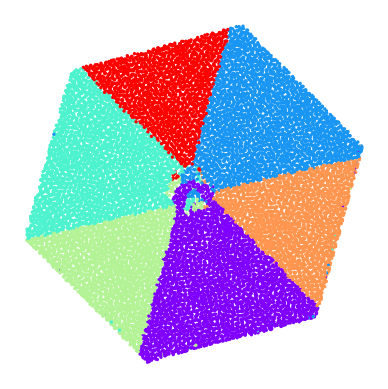

In [337]:
fig, ax = plt.subplots()
# ax.set_xlabel('x (m)')
# ax.set_ylabel('y (m)')
ax.set_xticks([])
ax.set_yticks([])
ax.grid(False)
for spine in ax.spines.values():
    spine.set_visible(False)

classification = classification-np.min(classification)

scatter = ax.scatter(x, y, c=classification, cmap="rainbow", s=2)
# cb = plt.colorbar(scatter)
# cb.set_label('z (m)')

ax.set_aspect("equal", adjustable='box')
plt.savefig("/home/jaumeasensio/Documents/TFM/Redacció memòria/Figures/Plane Identification/Steps SubFigures/KPlanes.png",dpi=200, bbox_inches='tight')
plt.show()

# Bad silhouette

In [41]:
basePath = "/home/jaumeasensio/Documents/Projectes/BEEGroup/solar_potencial_estimation_v3/"
neighborhood = "Test_70_el Besòs i el Maresme"
parcelsFolder = basePath + "/Results/" + neighborhood + "/Parcels/"
parcel = "4151302DF3845A"
construction = "139"

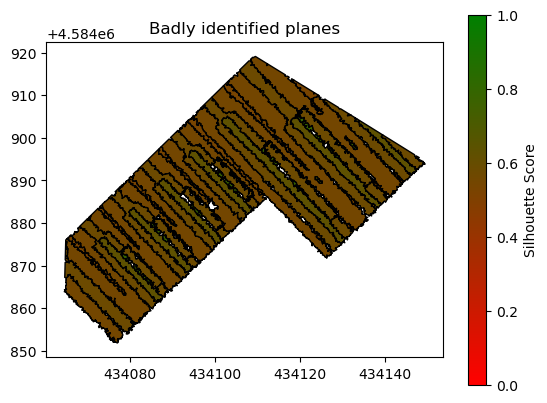

In [47]:
import geopandas as gpd
from matplotlib.colors import LinearSegmentedColormap

planeIDfile = parcelsFolder + parcel + "/" + construction + "/Plane Identification/" + construction + ".gpkg"


red_to_green = LinearSegmentedColormap.from_list("RedToGreen", ["red", "green"])

fig, ax = plt.subplots(1, 1)
planesGDF = gpd.read_file(planeIDfile)
plot = planesGDF.plot(column="silhouette", edgecolor="black", cmap=red_to_green, legend=False, ax=ax, vmin=0, vmax=1)

sm = plt.cm.ScalarMappable(cmap=red_to_green, norm=plt.Normalize(vmin=0, vmax=1))
sm._A = []  # Required for ScalarMappable
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Silhouette Score")

ax.set_aspect('equal', 'box')
# Show the plot
plt.title("Badly identified planes")
plt.savefig("/home/jaumeasensio/Documents/TFM/Redacció memòria/Figures/Plane Identification/BadSilhouettePlanes.png", dpi=200)
plt.show()

In [23]:
planesGDF

,cluster,A,B,D,tilt,azimuth,silhouette,geometry
0,3,0.000525,-0.001414,6267.491388,0.086,339.609312,0.632105,"MULTIPOLYGON (((434080.216 4584868.026, 434080..."
1,1,-0.002696,0.003604,-15339.911648,0.258,143.199484,0.550025,"MULTIPOLYGON (((434069.072 4584859.8, 434069.0..."
2,6,-0.002306,0.002437,-10156.520736,0.192,136.576583,0.784021,"MULTIPOLYGON (((434084.979 4584865.471, 434084..."
3,4,-0.004890,0.005858,-24720.604463,0.437,140.146805,0.575725,"MULTIPOLYGON (((434084.144 4584866.936, 434084..."
4,2,0.001489,-0.001605,6727.359617,0.125,317.159530,0.577156,"MULTIPOLYGON (((434068.425 4584864.58, 434068...."
5,5,0.009796,-0.008566,35033.280388,0.746,311.166152,0.527838,"MULTIPOLYGON (((434077.643 4584864.017, 434077..."
6,9,0.002550,0.005292,-25357.881718,0.337,205.730477,0.682637,"MULTIPOLYGON (((434123.957 4584890.288, 434123..."
7,7,0.084187,0.078963,-398571.510660,6.584,226.833979,0.766012,"MULTIPOLYGON (((434132.304 4584898.002, 434132..."


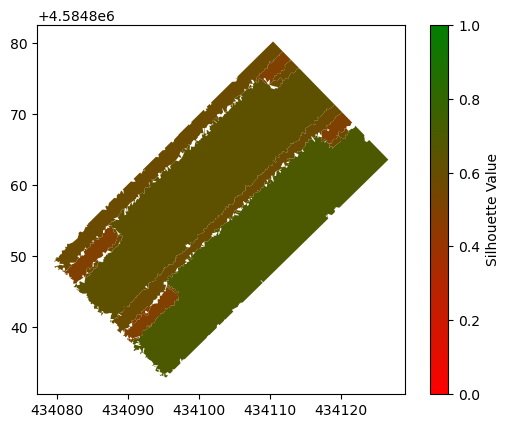

In [30]:
planeIDfile = parcelsFolder + parcel + "/" + "305" + "/Plane Identification/" + "305" + ".gpkg"

red_to_green = LinearSegmentedColormap.from_list("RedToGreen", ["red", "green"])

fig, ax = plt.subplots(1, 1)
planesGDF = gpd.read_file(planeIDfile)
plot = planesGDF.plot(column="silhouette", cmap=red_to_green, legend=False, ax=ax, vmin=0, vmax=1)

sm = plt.cm.ScalarMappable(cmap=red_to_green, norm=plt.Normalize(vmin=0, vmax=1))
sm._A = []  # Required for ScalarMappable
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Silhouette Value")

ax.set_aspect('equal', 'box')
# Show the plot
plt.show()

<Axes: >

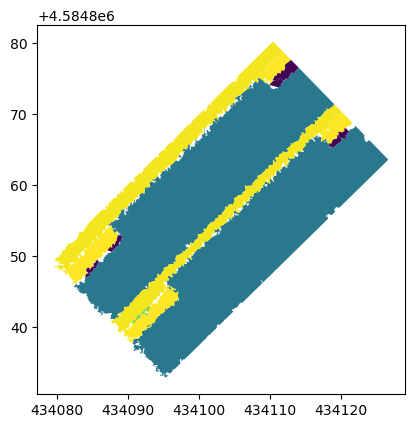

In [40]:
planesGDF.plot(column="azimuth")

In [33]:
planesGDF

,cluster,A,B,D,tilt,azimuth,silhouette,geometry
0,10,0.094568,-0.016435,34319.969419,5.483,279.859072,0.493365,"MULTIPOLYGON (((434091.102 4584840.726, 434091..."
1,1,-0.206830,0.211670,-880671.488866,16.486,135.662640,0.695680,"MULTIPOLYGON (((434093.559 4584834.702, 434093..."
2,4,0.010996,-0.022029,96247.113992,1.410,333.474612,0.498206,"MULTIPOLYGON (((434082.338 4584846.6, 434082.3..."
3,2,-0.198177,0.202493,-842353.545552,15.819,135.617183,0.635954,"MULTIPOLYGON (((434085.63 4584842.891, 434085...."
4,3,0.009680,-0.015250,65736.585297,1.035,327.594505,0.582148,"MULTIPOLYGON (((434080.843 4584848.393, 434080..."
5,5,-0.000693,-0.015756,72560.472075,0.904,2.519547,0.575196,"MULTIPOLYGON (((434084.5 4584847.62, 434084.5 ..."


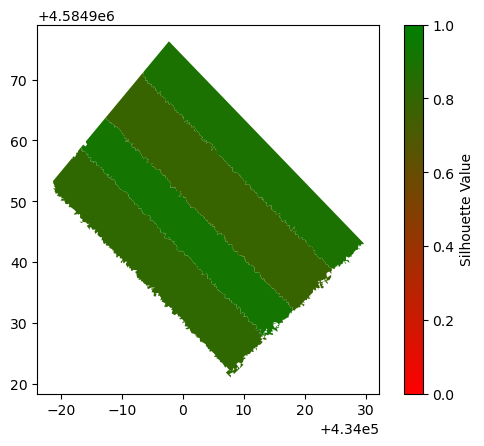

In [27]:

planeIDfile = basePath + "/Results/Test_70_el Besòs i el Maresme/Parcels/4151314DF3845A/672/Plane Identification/672.gpkg"

red_to_green = LinearSegmentedColormap.from_list("RedToGreen", ["red", "green"])

fig, ax = plt.subplots(1, 1)
planesGDF = gpd.read_file(planeIDfile)
plot = planesGDF.plot(column="silhouette", cmap=red_to_green, legend=False, ax=ax, vmin=0, vmax=1)

sm = plt.cm.ScalarMappable(cmap=red_to_green, norm=plt.Normalize(vmin=0, vmax=1))
sm._A = []  # Required for ScalarMappable
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Silhouette Value")

ax.set_aspect('equal', 'box')
# Show the plot
plt.show()

In [28]:
planesGDF

,cluster,A,B,D,tilt,azimuth,silhouette,geometry
0,5,-0.088003,-0.085343,4.294967e+05,6.989,45.879068,0.824983,"POLYGON ((434007.559 4584922.32, 434007.559 45..."
1,2,0.242757,0.237505,-1.194289e+06,18.758,225.626562,0.813842,"POLYGON ((433982.499 4584948.287, 433982.499 4..."
2,4,-0.255344,-0.247064,1.243605e+06,19.560,45.944218,0.921865,"POLYGON ((433986.881 4584954.958, 433986.881 4..."
3,1,0.227346,0.225374,-1.131985e+06,17.751,225.249613,0.778544,"POLYGON ((433992.258 4584958.59, 433992.258 45..."
4,3,-0.249208,-0.241750,1.216585e+06,19.147,45.870307,0.888561,"POLYGON ((433997.004 4584966.95, 433997.005 45..."


In [25]:
planesGDF

,cluster,A,B,D,tilt,azimuth,silhouette,geometry
0,10,0.094568,-0.016435,34319.969419,5.483,279.859072,0.493365,"MULTIPOLYGON (((434091.102 4584840.726, 434091..."
1,1,-0.206830,0.211670,-880671.488866,16.486,135.662640,0.695680,"MULTIPOLYGON (((434093.559 4584834.702, 434093..."
2,4,0.010996,-0.022029,96247.113992,1.410,333.474612,0.498206,"MULTIPOLYGON (((434082.338 4584846.6, 434082.3..."
3,2,-0.198177,0.202493,-842353.545552,15.819,135.617183,0.635954,"MULTIPOLYGON (((434085.63 4584842.891, 434085...."
4,3,0.009680,-0.015250,65736.585297,1.035,327.594505,0.582148,"MULTIPOLYGON (((434080.843 4584848.393, 434080..."
5,5,-0.000693,-0.015756,72560.472075,0.904,2.519547,0.575196,"MULTIPOLYGON (((434084.5 4584847.62, 434084.5 ..."


In [18]:
planesGDF

,cluster,A,B,D,tilt,azimuth,silhouette,geometry
0,3,0.000525,-0.001414,6267.491388,0.086,339.609312,0.632105,"MULTIPOLYGON (((434080.216 4584868.026, 434080..."
1,1,-0.002696,0.003604,-15339.911648,0.258,143.199484,0.550025,"MULTIPOLYGON (((434069.072 4584859.8, 434069.0..."
2,6,-0.002306,0.002437,-10156.520736,0.192,136.576583,0.784021,"MULTIPOLYGON (((434084.979 4584865.471, 434084..."
3,4,-0.004890,0.005858,-24720.604463,0.437,140.146805,0.575725,"MULTIPOLYGON (((434084.144 4584866.936, 434084..."
4,2,0.001489,-0.001605,6727.359617,0.125,317.159530,0.577156,"MULTIPOLYGON (((434068.425 4584864.58, 434068...."
5,5,0.009796,-0.008566,35033.280388,0.746,311.166152,0.527838,"MULTIPOLYGON (((434077.643 4584864.017, 434077..."
6,9,0.002550,0.005292,-25357.881718,0.337,205.730477,0.682637,"MULTIPOLYGON (((434123.957 4584890.288, 434123..."
7,7,0.084187,0.078963,-398571.510660,6.584,226.833979,0.766012,"MULTIPOLYGON (((434132.304 4584898.002, 434132..."


# Deprecated, get each histogram

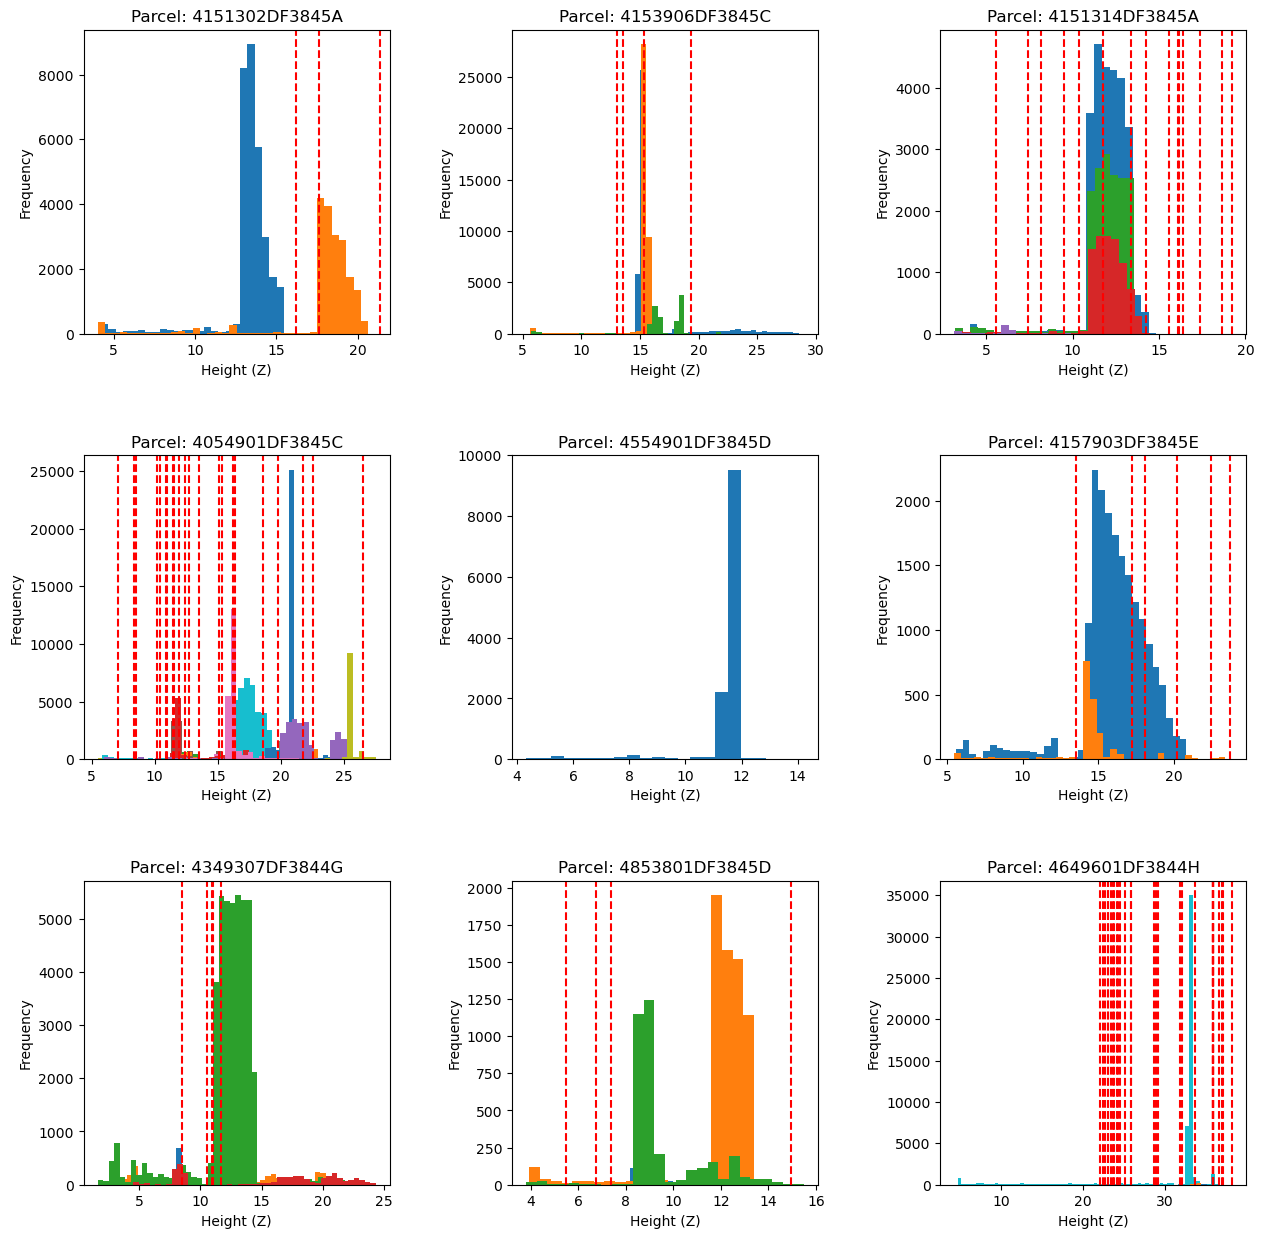

In [20]:
basePath = "/home/jaumeasensio/Documents/Projectes/BEEGroup/solar_potencial_estimation_v3/"
neighborhood = "Test_70_el Besòs i el Maresme"
parcelsFolder = basePath + "/Results/" + neighborhood + "/Parcels/"

distance_threshold = 0.45

parcels = [parcel for parcel in os.listdir(parcelsFolder) if os.path.isdir(parcelsFolder + parcel)]
num_parcels = len(parcels)

grid_size = 3
fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for idx, parcel in enumerate(parcels):
    row, col = divmod(idx, grid_size)  # Determine grid position
    ax = axes[row, col]  # Get the current subplot
    ax.set_title(f"Parcel: {parcel}")

    parcelSubfolder = parcelsFolder + parcel + "/"

    constructions = [x for x in os.listdir(parcelSubfolder) if os.path.isdir(parcelSubfolder + x)]
    num_constructions = len(constructions)

    nested_fig, nested_axes = plt.subplots(num_constructions, 1, sharex=True, figsize=(5, num_constructions * 2))
    nested_axes = np.atleast_1d(nested_axes)

    for construction in [x for x in os.listdir(parcelSubfolder) if os.path.isdir(parcelSubfolder + x)]:
        constructionFolder = parcelSubfolder + construction
        lasPath = constructionFolder + "/Map files/" + construction + ".laz"
        lasDF = laspy.read(lasPath)
        Z = np.array(lasDF.z)
        Z = Z[Z.argsort()]         
        deltaZ = np.diff(Z, prepend=0)
        
        heightSplits = []
        for i in range(1, len(deltaZ)):
            if deltaZ[i] > distance_threshold:
                heightSplits.append(Z[i])

        bins = np.arange(np.min(Z), np.max(Z), distance_threshold)
        ax.hist(Z, bins)
        for split in heightSplits:
            ax.axvline(x=split, color='red', linestyle='--', linewidth=1.5)
    
    ax.set_xlabel("Height (Z)")
    ax.set_ylabel("Frequency")

plt.show()

In [12]:
np.array(Z)

array([6.148, 5.098, 4.77 , ..., 4.707, 4.798, 5.634])